# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [105]:
# Import required libraries

import numpy as np
import seaborn as sns
import pandas as pd
import patsy
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.cross_validation import KFold
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_predict



In [106]:
## Required for graphing within Jupyter/ipython
%matplotlib inline

## Load the data into a DataFrame
df = pd.read_csv('starter-code/Iowa_Liquor_sales_sample_10pct.csv')

## Transform the dates if needed, e.g.
df["Date"] = pd.to_datetime(df["Date"],infer_datetime_format=True)

## Rename some columns for ease of future operations
df = df.rename(columns={'Date':'date', 'Store Number': 'storenumber', 'Zip Code': 'zipcode', 
                        'City':'city', 'Vendor Number': 'vendornumber', 'County Number': 'countynumber', 
                        'County':'county','Bottle Volume (ml)':'bv_ml', 'State Bottle Cost':'sbc', 
                        'Category':'category','State Bottle Retail': 'sbr', 'Bottles Sold':'bottles_sold', 
                        'Category Name':'categoryname','Sale (Dollars)': 'sale_in_dollars', 
                        'Volume Sold (Liters)':'vs_lit', 'Volume Sold (Gallons)':'vs_gal', 
                        'Item Number':'itemnumber', 'Item Description':'itemdesc'})

## Strip '$' from columns containing dollar amounts to aid pandas operations on respective columns

df['sale_in_dollars'] = df['sale_in_dollars'].apply(lambda x: float(x[1:]))
df['sbc'] = df['sbc'].apply(lambda x: float(x[1:]))
df['sbr'] = df['sbr'].apply(lambda x: float(x[1:]))

# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [107]:
df.head(3)

,date,storenumber,city,zipcode,countynumber,county,category,categoryname,vendornumber,itemnumber,itemdesc,bv_ml,sbc,sbr,bottles_sold,sale_in_dollars,vs_lit,vs_gal
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.0,2.38
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,13.75,20.63,2,41.26,1.5,0.40
2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,12.59,18.89,24,453.36,24.0,6.34


In [108]:
# For columns expected to contain only values of types int and float,
# one easy test for invalid values (anything non-numeric besides NaN)
# would be to try to temporarily cast the entire column as type int64
# or float64. Should there be presence of invalid values, we can then
# investigate the column further. 

numint_columns = ['storenumber','zipcode','vendornumber','itemnumber','bv_ml']
numflt_columns = ['countynumber','category','sbc','sbr','sale_in_dollars','vs_lit','vs_gal']


## Iterate through columns and attempt to typecast columns that 
## are known to be castable as integers. 
for ncol in numint_columns:
    try:
        df[ncol].astype('int64')
    except:
        print "Problem casting type for column %s"%ncol

## Iterate through columns and attempt to typecast columns that 
## are known to be castable as float. 

for ncol in numflt_columns:
    try:
        df[ncol].astype('float64')
    except:
        print "Problem casting type for column %s"%ncol


Problem casting type for column zipcode


In [109]:
# Issues found with the column 'zipcode'
# As the expected format of this column is a 5-digit integer, match values
# against the appropriate regular expression and return all rows failing
# the comparison. 

import re
from collections import Counter

## Build an index of indexes for any values in column zipcode that do not
## meet the known integer format for zipcodes.

indices = [i for i, x in enumerate(df['zipcode']) if not re.search(r'^\d{5}$', x)]

print "DataFrame Row positions of invalid Zip Codes:%s"%Counter(df['zipcode'][indices])

# After finding the rows of invalid values, try looking at some other columns
# relating to geographic data to see if the invalid or missing zip code(s) can be
# imputed from other data. 
print "Corresponding County names of invalid Zip Codes: %s"%Counter(df['county'][indices])
print "Corresponding City names of invalid Zip Codes: %s"%Counter(df['city'][indices])

DataFrame Row positions of invalid Zip Codes:Counter({'712-2': 217})
Corresponding County names of invalid Zip Codes: Counter({'Harrison': 186, nan: 31})
Corresponding City names of invalid Zip Codes: Counter({'DUNLAP': 217})


### Imputation Notes:
Based on the above, we can infer that the missing zip codes are in fact for the city of Dunlap, IA. Luckily, Dunlap only has one zip code for the city (51529) so it is reasonable to impute that the missing zip code is 51529. 

In [110]:
# Replace invalid Zip Code values
df['zipcode'] = df['zipcode'].replace('712-2','51529')

# Re-attempt type conversion of column to verify correction
try:
    df['zipcode'].astype('int64')
    print "Column dtype conversion test OK."
except:
    print "Dtype conversion failed."

Column dtype conversion test OK.


In [111]:
# Iowa Zip Codes are within the range of 50000 and 53000. 
# Check if any zip codes are outside this range. 

zip_bound_indices = [i for i, x in enumerate(df['zipcode']) if not ((int(x)>=50000) & (int(x)<=53000))]
print "Zip codes found outside acceptable range: %s"%Counter(df['zipcode'][zip_bound_indices])

Zip codes found outside acceptable range: Counter({'56201': 23})


In [112]:
df['city'][zip_bound_indices].describe()

count             23
unique             1
top       BURLINGTON
freq              23
Name: city, dtype: object

Zip code 56201 is associated with Wilmar, MN. However, when looking at city/county information for that row, we see that the zip code has been entered incorrectly. The city for those rows is identified as Burlington, whose zip code is 52601. As it appears the zip code has just been entered incorrectly, it is reasonable to assume that we can make the correction for the affected entries. 

In [137]:
df['zipcode'] = df['zipcode'].replace('56201','52601')

In [114]:
# Create County information dictionary

county_registrar = {}

for i in range(0, len(df)):
    if not len(df['zipcode'][i])==0:
        if not df['zipcode'][i] in county_registrar.values():
            county_registrar[df['zipcode'][i]] = [df['countynumber'][i],df['county'][i]]
        else:
            county_registrar[df['zipcode'][i]].append(df['countynumber'][i],df['county'][i])

In [115]:
## Build a list of indexes of invalid/missing cells where the
## county name should be present. 

bad_county_indices = np.where(df['county'].isnull())[0].tolist()

In [116]:
## Using the dictionary variable that was created, cross-reference
## the indexes of cells missing county values with the county
## value corresponding to the zip code in the dictionary. Replace
## if the zip code exists in the dictionary.

for bci in bad_county_indices:
    df.set_value(bci,'county',county_registrar[df.iloc[bci].zipcode][1])
    df.set_value(bci,'countynumber',float(county_registrar[df.iloc[bci].zipcode][0]))

In [117]:
## As there may still be missing values, this is an additional 
## check to see if there is the possibility of the cells 
## existing that have no cross-referenceable values defined
## in the dictionary

null_county_indices = np.where(df['county'].isnull())[0].tolist()

In [118]:
# Completing the data set

# We are able to manually impute the remaining county and county number values
# Remaining cities are Runnels, Seymour, and Tabor. 
# Tabor is in Fremont County - county number : 36
# Seymour is in Wayne County - county number : 93
# Runnels is in Polk County - county number : 77

for nullcountycity in null_county_indices:
    if df.ix[nullcountycity]['city']=='TABOR':
        df.set_value(nullcountycity,'county','Fremont')
        df.set_value(nullcountycity,'countynumber',36.0)        
    elif df.ix[nullcountycity]['city']=='RUNNELLS':
        df.set_value(nullcountycity,'county','Polk')
        df.set_value(nullcountycity,'countynumber',77.0)        
    elif df.ix[nullcountycity]['city']=='SEYMOUR':
        df.set_value(nullcountycity,'county','Wayne')
        df.set_value(nullcountycity,'countynumber',93.0)        


In [119]:
# Create two separate dataframes based on 

ias_2015 = df.loc[(df['date'] >= '2015-01-01') & (df['date'] <= '2015-12-31')].reset_index(drop=True)
ias_2016 = df.loc[(df['date'] >= '2016-01-01') & (df['date'] <= '2016-12-31')].reset_index(drop=True)

In [120]:
# Annual Sales Total Per Store

ias_store_totals_2015 = ias_2015.groupby('storenumber')['bottles_sold','sale_in_dollars'].sum()

# Show sample data
ias_store_totals_2015.head(5)

,bottles_sold,sale_in_dollars
storenumber,,
2106,10367,146326.22
2113,671,9310.22
2130,7430,111871.43
2152,573,7721.08
2178,1928,24324.18


In [121]:
# Add additional statistics into new columns as they are calculated.

ias_store_totals_2015['avgticket']=ias_store_totals_2015['sale_in_dollars']/ias_store_totals_2015['bottles_sold']
ias_store_totals_2015['avgcost']=ias_2015.groupby('storenumber')['sbc'].mean()
ias_store_totals_2015['avgretail']=ias_2015.groupby('storenumber')['sbr'].mean()
ias_store_totals_2015['avgvol']=ias_2015.groupby('storenumber')['vs_gal'].mean()
ias_store_totals_2015['avgprofit']=ias_store_totals_2015['avgretail']-ias_store_totals_2015['avgcost']

In [122]:
# Sample of data for dataframe of store totals and averages

ias_store_totals_2015.head()

,bottles_sold,sale_in_dollars,avgticket,avgcost,avgretail,avgvol,avgprofit
storenumber,,,,,,,
2106,10367,146326.22,14.114616,10.309545,15.475863,4.879184,5.166319
2113,671,9310.22,13.875142,10.870544,16.315646,1.185646,5.445102
2130,7430,111871.43,15.056720,9.838444,14.764286,4.644515,4.925842
2152,573,7721.08,13.474834,8.565035,12.887660,1.186383,4.322624
2178,1928,24324.18,12.616276,9.689831,14.558692,2.137131,4.868861


In [123]:
# Process outliers by taking any values beyond three std deviations away from the mean
# and repacing it with the mean.

for cols in ias_store_totals_2015.columns:
    for storenum in ias_store_totals_2015[cols].index:
        if not np.abs(ias_store_totals_2015[cols][storenum]-
                      ias_store_totals_2015[cols].mean())<=(3*ias_store_totals_2015[cols].std()):
            ias_store_totals_2015[cols][storenum] = ias_store_totals_2015[cols].mean()

/Users/homerj/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


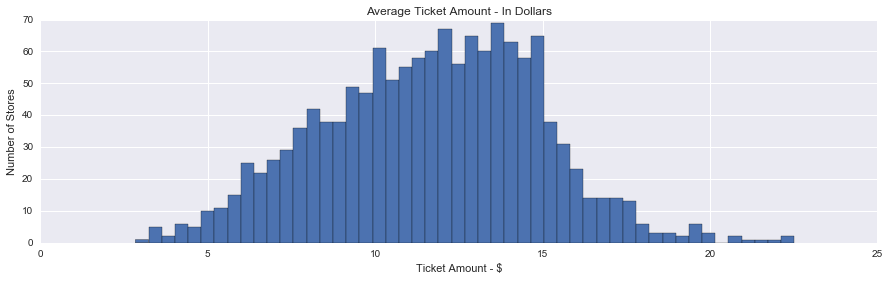

In [124]:
## Generate a graph showing the number of stores based on the 
## average ticket amounts of each transaction. 

plt.figure(figsize=(15,4))
plt.hist(ias_store_totals_2015['avgticket'],bins=50)
plt.title("Average Ticket Amount - In Dollars")
plt.ylabel("Number of Stores")
plt.xlabel("Ticket Amount - $")
plt.show()

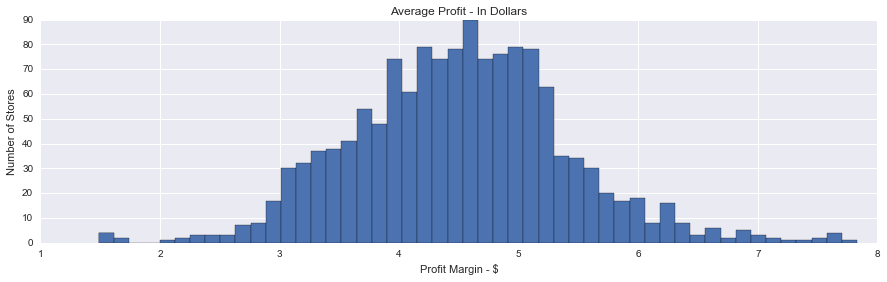

In [125]:
## Generate a graph showing the number of stores based on the 
## average profit margin of each transaction. 

plt.figure(figsize=(15,4))
plt.hist(ias_store_totals_2015['avgprofit'],bins=50)
plt.title("Average Profit - In Dollars")
plt.ylabel("Number of Stores")
plt.xlabel("Profit Margin - $")
plt.show()

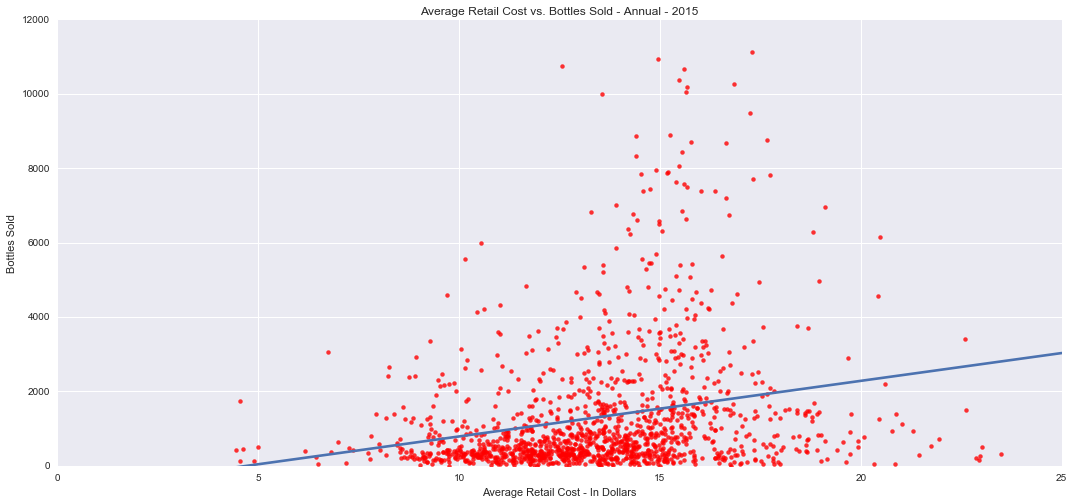

In [126]:
## Generate a plot showing the number of bottles sold versus the 
## average cost of a bottle. 

fig, plt1 = plt.subplots()
fig.set_size_inches(18, 8)
sns.regplot(ias_store_totals_2015.avgretail, ias_store_totals_2015.bottles_sold, order=1, ci=None, scatter_kws={'color':'r'})
plt.xlim(xmin=0) 
plt.ylim(ymin=0)
plt.title("Average Retail Cost vs. Bottles Sold - Annual - 2015")
plt.ylabel("Bottles Sold")
plt.xlabel("Average Retail Cost - In Dollars")
plt.show()

In [127]:
## Linear Regression testing of a model based on 
## bottles sold versus the bottle retail price.

y, X = patsy.dmatrices('bottles_sold ~ avgretail',
                       data=ias_store_totals_2015, 
                       return_type='dataframe')
model = sm.OLS(y, X)
results = model.fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:           bottles_sold   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     80.21
Date:                Fri, 23 Sep 2016   Prob (F-statistic):           1.07e-18
Time:                        07:55:27   Log-Likelihood:                -12125.
No. Observations:                1372   AIC:                         2.425e+04
Df Residuals:                    1370   BIC:                         2.426e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   -706.9888    229.481     -3.081      0.0

In [128]:
## Break down the data into quarterly subsets for 2015 and Q1 of 2016

ias_2015_q1 = ias_2015.loc[(ias_2015['date'] >= '2015-01-01') & 
                           (ias_2015['date'] <= '2015-03-31')].reset_index(drop=True)
ias_2015_q2 = ias_2015.loc[(ias_2015['date'] >= '2015-04-01') & 
                           (ias_2015['date'] <= '2015-06-30')].reset_index(drop=True)
ias_2015_q3 = ias_2015.loc[(ias_2015['date'] >= '2015-07-01') & 
                           (ias_2015['date'] <= '2015-09-30')].reset_index(drop=True)
ias_2015_q4 = ias_2015.loc[(ias_2015['date'] >= '2015-10-01') & 
                           (ias_2015['date'] <= '2015-12-31')].reset_index(drop=True)

ias_2016_q1 = ias_2016.loc[(ias_2016['date'] >= '2016-01-01') & 
                           (ias_2016['date'] <= '2016-03-31')].reset_index(drop=True)

In [129]:
# Create additional tables based on bottles sold, retail prices, and wholesale costs.

ias_2015_q1_bs = ias_2015_q1.groupby('date')['bottles_sold'].sum()
ias_2015_q2_bs = ias_2015_q2.groupby('date')['bottles_sold'].sum()
ias_2015_q3_bs = ias_2015_q3.groupby('date')['bottles_sold'].sum()
ias_2015_q4_bs = ias_2015_q4.groupby('date')['bottles_sold'].sum()

ias_2016_q1_bs = ias_2016_q1.groupby('date')['bottles_sold'].sum()

ias_2015_q1_br = ias_2015_q1.groupby('date')['sbr'].mean()
ias_2015_q2_br = ias_2015_q2.groupby('date')['sbr'].mean()
ias_2015_q3_br = ias_2015_q3.groupby('date')['sbr'].mean()
ias_2015_q4_br = ias_2015_q4.groupby('date')['sbr'].mean()

ias_2015_q1_bc = ias_2015_q1.groupby('date')['sbc'].mean()
ias_2015_q2_bc = ias_2015_q2.groupby('date')['sbc'].mean()
ias_2015_q3_bc = ias_2015_q3.groupby('date')['sbc'].mean()
ias_2015_q4_bc = ias_2015_q4.groupby('date')['sbc'].mean()

In [130]:
## This section is for detecting and removing outliers from our data.
## The for loops below iterate through each line and replace 
## values more than 3 std. deviations away from the mean with the 
## mean value. The mean value was used after seeing that the 
## distribution appears normal. 

for x in range(0,ias_2015_q1_bs.count()):
    if not np.abs(ias_2015_q1_bs[x]-ias_2015_q1_bs.mean())<=(3*ias_2015_q1_bs.std()):
        ias_2015_q1_bs[x] = ias_2015_q1_bs.mean()
        
for x in range(0,ias_2015_q2_bs.count()):
    if not np.abs(ias_2015_q2_bs[x]-ias_2015_q2_bs.mean())<=(3*ias_2015_q2_bs.std()):
        ias_2015_q2_bs[x] = ias_2015_q2_bs.mean()
        
for x in range(0,ias_2015_q3_bs.count()):
    if not np.abs(ias_2015_q3_bs[x]-ias_2015_q3_bs.mean())<=(3*ias_2015_q3_bs.std()):
        ias_2015_q3_bs[x] = ias_2015_q3_bs.mean()
        
for x in range(0,ias_2015_q4_bs.count()):
    if not np.abs(ias_2015_q4_bs[x]-ias_2015_q4_bs.mean())<=(2*ias_2015_q4_bs.std()):
        ias_2015_q4_bs[x] = ias_2015_q4_bs.mean()


for x in range(0,ias_2016_q1_bs.count()):
    if not np.abs(ias_2016_q1_bs[x]-ias_2016_q1_bs.mean())<=(2*ias_2016_q1_bs.std()):
        ias_2016_q1_bs[x] = ias_2016_q1_bs.mean()

        
        
for x in range(0,ias_2015_q1_br.count()):
    if not np.abs(ias_2015_q1_br[x]-ias_2015_q1_br.mean())<=(3*ias_2015_q1_br.std()):
        ias_2015_q1_br[x] = ias_2015_q1_br.mean()
        
for x in range(0,ias_2015_q2_br.count()):
    if not np.abs(ias_2015_q2_br[x]-ias_2015_q2_br.mean())<=(3*ias_2015_q2_br.std()):
        ias_2015_q2_br[x] = ias_2015_q2_br.mean()
        
for x in range(0,ias_2015_q3_br.count()):
    if not np.abs(ias_2015_q3_br[x]-ias_2015_q3_br.mean())<=(3*ias_2015_q3_br.std()):
        ias_2015_q3_br[x] = ias_2015_q3_br.mean()
        
for x in range(0,ias_2015_q4_br.count()):
    if not np.abs(ias_2015_q4_br[x]-ias_2015_q4_br.mean())<=(3*ias_2015_q4_br.std()):
        ias_2015_q4_br[x] = ias_2015_q4_br.mean()

        
        
for x in range(0,ias_2015_q1_bc.count()):
    if not np.abs(ias_2015_q1_bc[x]-ias_2015_q1_bc.mean())<=(2*ias_2015_q1_bc.std()):
        ias_2015_q1_bc[x] = ias_2015_q1_bc.mean()
        
for x in range(0,ias_2015_q2_bc.count()):
    if not np.abs(ias_2015_q2_bc[x]-ias_2015_q2_bc.mean())<=(2*ias_2015_q2_bc.std()):
        ias_2015_q2_bc[x] = ias_2015_q2_bc.mean()
        
for x in range(0,ias_2015_q3_bc.count()):
    if not np.abs(ias_2015_q3_bc[x]-ias_2015_q3_bc.mean())<=(2*ias_2015_q3_bc.std()):
        ias_2015_q3_bc[x] = ias_2015_q3_bc.mean()
        
for x in range(0,ias_2015_q4_bc.count()):
    if not np.abs(ias_2015_q4_bc[x]-ias_2015_q4_bc.mean())<=(2*ias_2015_q4_bc.std()):
        ias_2015_q4_bc[x] = ias_2015_q4_bc.mean()

In [131]:
## Create datasets that are scaled down with respect to time. 
## Any graphs generated based off these variables will be
## easier to read but at the cost of loss of granularity.

ias_2015_q1_bs_weekly = ias_2015_q1_bs.resample('W').sum()
ias_2015_q2_bs_weekly = ias_2015_q2_bs.resample('W').sum()
ias_2015_q3_bs_weekly = ias_2015_q3_bs.resample('W').sum()
ias_2015_q4_bs_weekly = ias_2015_q4_bs.resample('W').sum()

ias_2015_q1_br_weekly = ias_2015_q1_br.resample('W').sum()
ias_2015_q2_br_weekly = ias_2015_q2_br.resample('W').sum()
ias_2015_q3_br_weekly = ias_2015_q3_br.resample('W').sum()
ias_2015_q4_br_weekly = ias_2015_q4_br.resample('W').sum()

ias_2015_q1_bc_weekly = ias_2015_q1_bc.resample('W').sum()
ias_2015_q2_bc_weekly = ias_2015_q2_bc.resample('W').sum()
ias_2015_q3_bc_weekly = ias_2015_q3_bc.resample('W').sum()
ias_2015_q4_bc_weekly = ias_2015_q4_bc.resample('W').sum()

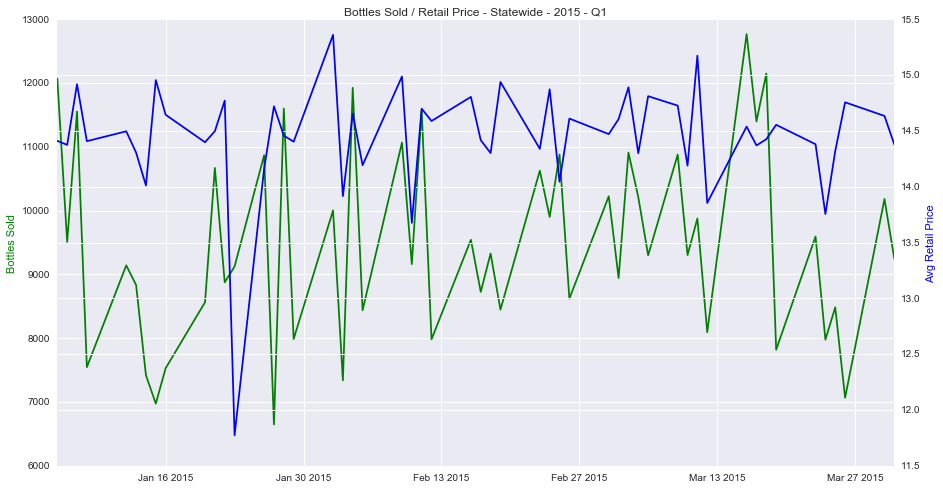

In [132]:
## Draw a plot showing the apparent correspondence of bottles
## sold versus the average retail price for Q1

fig, plt1 = plt.subplots()

plt2 = plt1.twinx()

fig.set_size_inches(15, 8)
plt.xlabel('Date')
plt.title('Bottles Sold / Retail Price - Statewide - 2015 - Q1')
plt1.plot(ias_2015_q1_bs, 'g-')
plt2.plot(ias_2015_q1_br, 'b-')
plt1.set_ylabel('Bottles Sold', color='g')
plt2.set_ylabel('Avg Retail Price', color='b')

plt.show()

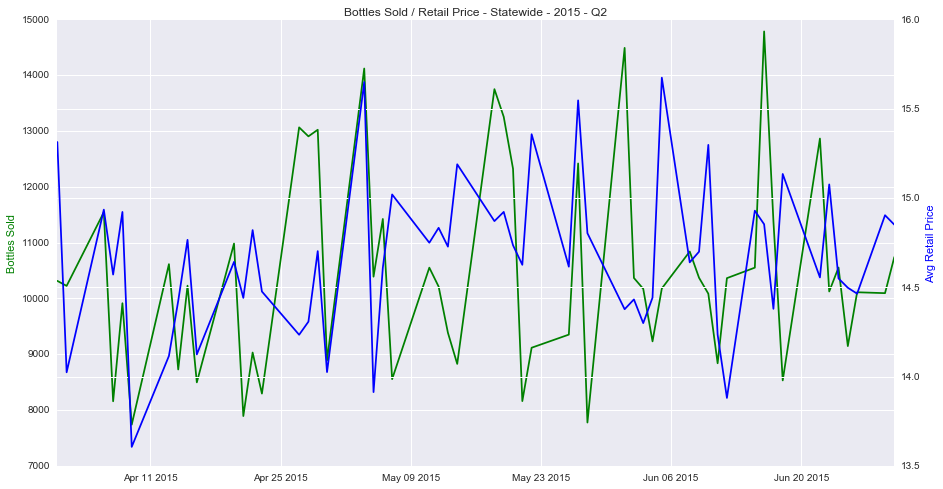

In [133]:
## Draw a plot showing the apparent correspondence of bottles
## sold versus the average retail price for Q2

fig, plt1 = plt.subplots()

plt2 = plt1.twinx()

fig.set_size_inches(15, 8)
plt.xlabel('Date')
plt.title('Bottles Sold / Retail Price - Statewide - 2015 - Q2')
plt1.plot(ias_2015_q2_bs, 'g-')
plt2.plot(ias_2015_q2_br, 'b-')
plt1.set_ylabel('Bottles Sold', color='g')
plt2.set_ylabel('Avg Retail Price', color='b')

plt.show()

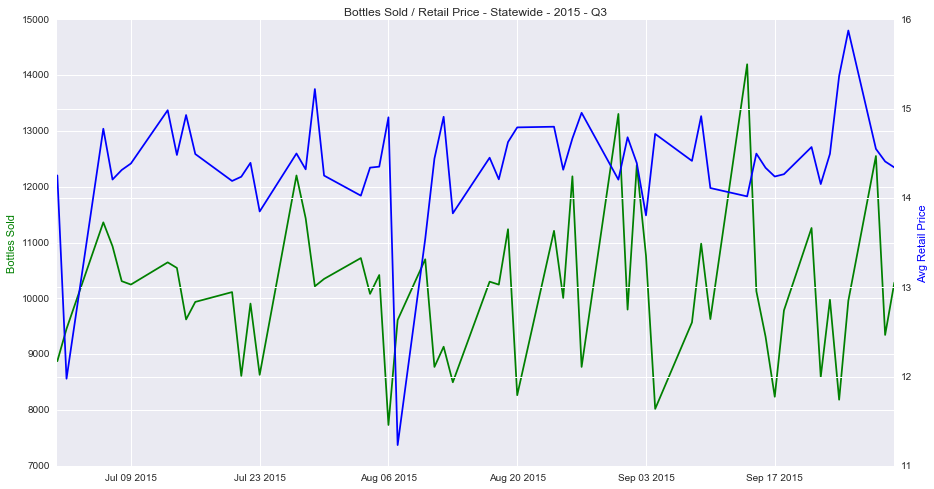

In [134]:
## Draw a plot showing the apparent correspondence of bottles
## sold versus the average retail price for Q3

fig, plt1 = plt.subplots()

plt2 = plt1.twinx()

fig.set_size_inches(15, 8)
plt.xlabel('Date')
plt.title('Bottles Sold / Retail Price - Statewide - 2015 - Q3')
plt1.plot(ias_2015_q3_bs, 'g-')
plt2.plot(ias_2015_q3_br, 'b-')
plt1.set_ylabel('Bottles Sold', color='g')
plt2.set_ylabel('Avg Retail Price', color='b')

plt.show()

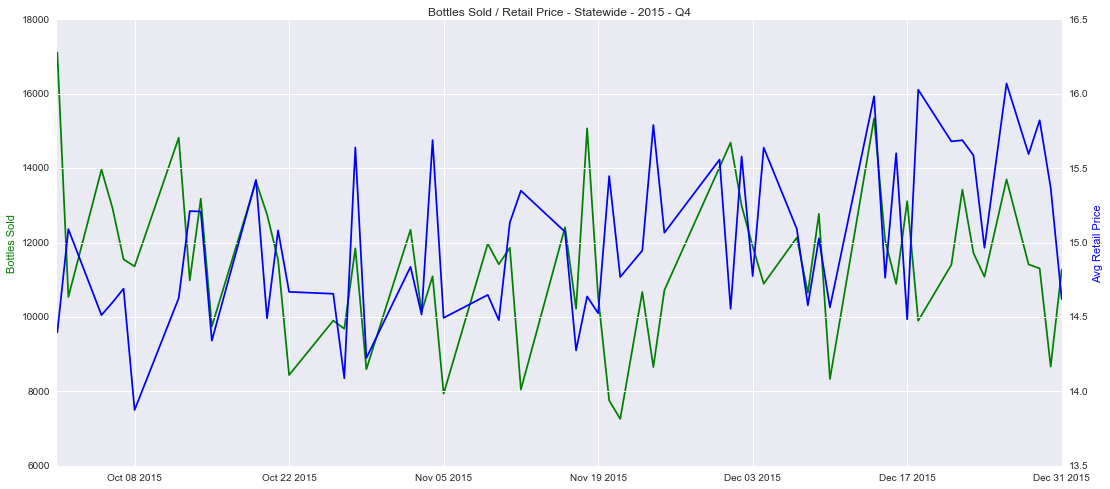

In [135]:
## Draw a plot showing the apparent correspondence of bottles
## sold versus the average retail price for Q4


fig, plt1 = plt.subplots()

plt2 = plt1.twinx()

fig.set_size_inches(18, 8)
plt.xlabel('Date')
plt.title('Bottles Sold / Retail Price - Statewide - 2015 - Q4')
plt1.plot(ias_2015_q4_bs, 'g-')
plt2.plot(ias_2015_q4_br, 'b-')
plt1.set_ylabel('Bottles Sold', color='g')
plt2.set_ylabel('Avg Retail Price', color='b')

plt.show()

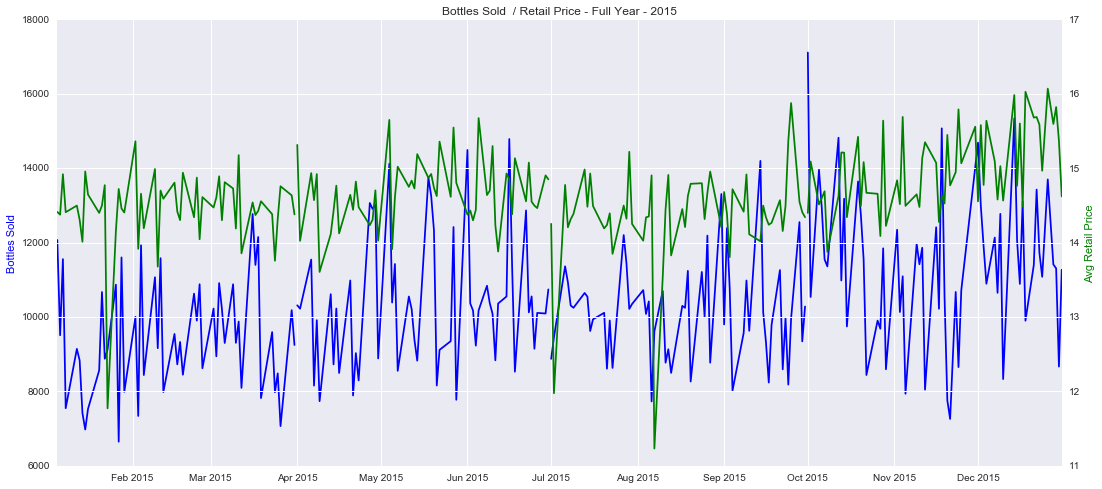

In [136]:
## Draw a plot showing the apparent correspondence of bottles
## sold versus the average retail price for all of 2015


fig, plt1 = plt.subplots()

plt2 = plt1.twinx()

fig.set_size_inches(18, 8)


plt.xlabel('Date')
plt.ylabel('Bottles Sold')
plt.title('Bottles Sold  / Retail Price - Full Year - 2015')

plt1.plot(ias_2015_q1_bs, 'b-')
plt1.plot(ias_2015_q2_bs, 'b-')
plt1.plot(ias_2015_q3_bs, 'b-')
plt1.plot(ias_2015_q4_bs, 'b-')

plt2.plot(ias_2015_q1_br, 'g-')
plt2.plot(ias_2015_q2_br, 'g-')
plt2.plot(ias_2015_q3_br, 'g-')
plt2.plot(ias_2015_q4_br, 'g-')

plt1.set_ylabel('Bottles Sold', color='b')
plt2.set_ylabel('Avg Retail Price', color='g')
plt.show()

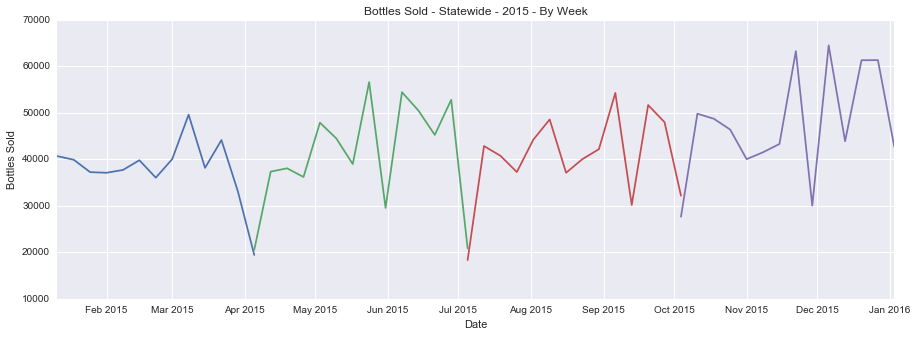

In [33]:
## Draw a plot showing the apparent correspondence of bottles
## sold versus the average retail price for all of 2015 but 
## on a weekly basis.

plt.figure(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Bottles Sold')
plt.title('Bottles Sold - Statewide - 2015 - By Week')
plt.plot(ias_2015_q1_bs_weekly)
plt.plot(ias_2015_q2_bs_weekly)
plt.plot(ias_2015_q3_bs_weekly)
plt.plot(ias_2015_q4_bs_weekly)
plt.show()

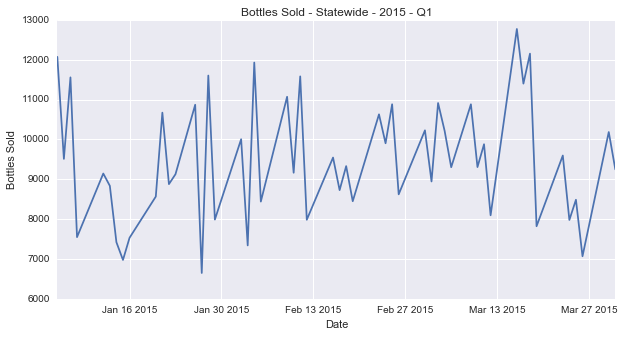

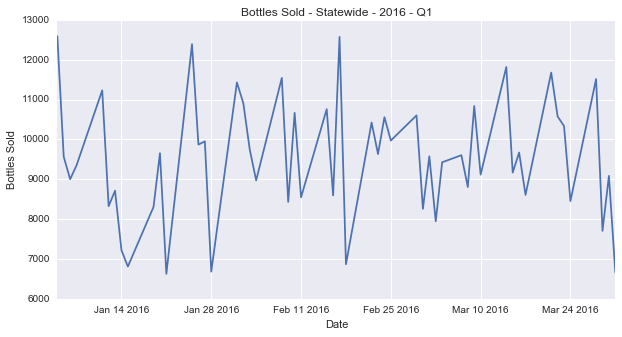

In [34]:
## Draw a plot showing the comparison between Q1 of 
## 2015 versus Q1 of 2016

plt.figure(figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Bottles Sold')
plt.title('Bottles Sold - Statewide - 2015 - Q1')
plt.plot(ias_2015_q1_bs)
plt.show()

plt.figure(figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Bottles Sold')
plt.title('Bottles Sold - Statewide - 2016 - Q1')
plt.plot(ias_2016_q1_bs)
plt.show()


In [70]:
## Calculate total sales volumne in Q1 of 2015

ias_2015_q1['sale_in_dollars'].sum()

6153795.8899996225

In [71]:
## Calculate total sales volumne in Q1 of 2016

ias_2016_q1['sale_in_dollars'].sum()

6399497.559999541

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

In [35]:
ias_2015_q1.head()

,date,storenumber,city,zipcode,countynumber,county,category,categoryname,vendornumber,itemnumber,itemdesc,bv_ml,sbc,sbr,bottles_sold,sale_in_dollars,vs_lit,vs_gal
0,2015-01-22,3858,DAVENPORT,52806,82.0,Scott,1012100.0,CANADIAN WHISKIES,65,15248,Windsor Canadian Pet,1750,8.92,13.38,1,13.38,1.75,0.46
1,2015-03-04,2614,DAVENPORT,52807,82.0,Scott,1012100.0,CANADIAN WHISKIES,434,13638,Lord Calvert Canadian Whisky,1750,9.97,14.96,6,89.76,10.50,2.77
2,2015-01-16,2590,CEDAR RAPIDS,52402,57.0,Linn,1031200.0,VODKA FLAVORED,971,41474,44 North Huckleberry,750,14.25,21.38,2,42.76,1.50,0.40
3,2015-01-13,3942,TOLEDO,52342,86.0,Tama,1012100.0,CANADIAN WHISKIES,115,11786,Black Velvet Traveler,750,5.23,7.85,12,94.20,9.00,2.38
4,2015-03-24,3981,SIOUX CENTER,51250,84.0,Sioux,1011100.0,BLENDED WHISKIES,260,25606,Seagrams 7 Crown Bl Whiskey,750,7.00,10.50,12,126.00,9.00,2.38


In [36]:
## Create copy dataframes for use in regression. Copy only numeric values. 

iasmod_2015_q1 = pd.DataFrame(data=ias_2015_q1,columns=
                              ['zipcode','countynumber','category','itemnumber',
                               'sbr','bottles_sold','sale_in_dollars'])
iasmod_2015_q2 = pd.DataFrame(data=ias_2015_q2,columns=
                              ['zipcode','countynumber','category','itemnumber',
                               'sbr','bottles_sold','sale_in_dollars'])
iasmod_2015_q3 = pd.DataFrame(data=ias_2015_q3,columns=
                              ['zipcode','countynumber','category','itemnumber',
                               'sbr','bottles_sold','sale_in_dollars'])
iasmod_2015_q4 = pd.DataFrame(data=ias_2015_q4,columns=
                              ['zipcode','countynumber','category','itemnumber',
                               'sbr','bottles_sold','sale_in_dollars'])

iasmod_2016_q1 = pd.DataFrame(data=ias_2016_q1,columns=
                              ['zipcode','countynumber','category','itemnumber',
                               'sbr','bottles_sold','sale_in_dollars'])

In [37]:
## Zip code is found to have been transferred over as type Object. Convert here.
iasmod_2015_q1['zipcode'] = iasmod_2015_q1['zipcode'].astype('int64')
iasmod_2015_q2['zipcode'] = iasmod_2015_q2['zipcode'].astype('int64')
iasmod_2015_q3['zipcode'] = iasmod_2015_q3['zipcode'].astype('int64')
iasmod_2015_q4['zipcode'] = iasmod_2015_q4['zipcode'].astype('int64')

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

In [38]:
# create regularize copies of data for comparison of results

cont_feats = ['bottles_sold', 'sbr', 'sale_in_dollars']
iasmod_2015_q1[cont_feats] = StandardScaler().fit_transform(
    iasmod_2015_q1[cont_feats]
)
iasmod_2015_q2[cont_feats] = StandardScaler().fit_transform(
    iasmod_2015_q2[cont_feats]
)
iasmod_2015_q3[cont_feats] = StandardScaler().fit_transform(
    iasmod_2015_q3[cont_feats]
)
iasmod_2015_q4[cont_feats] = StandardScaler().fit_transform(
    iasmod_2015_q4[cont_feats]
)

In [ ]:
## Generate correlation data for each quarter

q1_2015_corr = ias_2015_q1.corr()
q2_2015_corr = ias_2015_q2.corr()
q3_2015_corr = ias_2015_q3.corr()
q4_2015_corr = ias_2015_q4.corr()

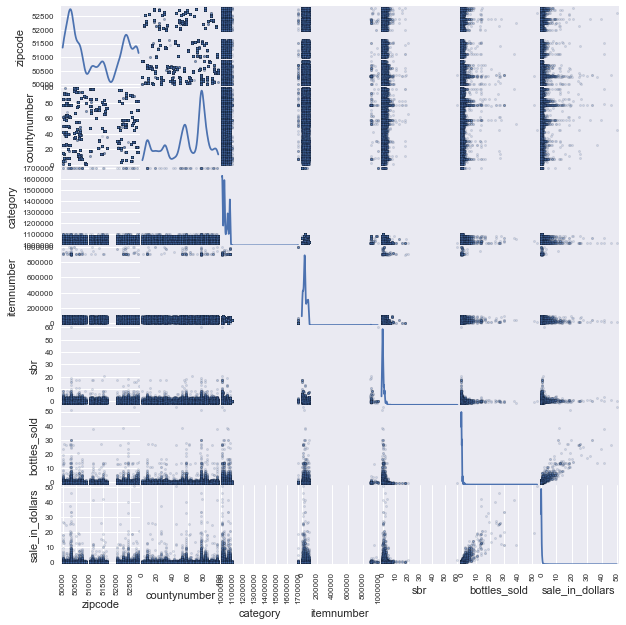

In [99]:
## Plot a scatter plot of correlation data for Q1

a=scatter_matrix(iasmod_2015_q1, alpha=0.2, figsize=(10, 10), diagonal='kde')

In [ ]:
######
# The heatmaps and regression methods below were adopted from code 
# presented to us in class and used as is. Any modifications are noted 
# separately to identify any changes made
#####

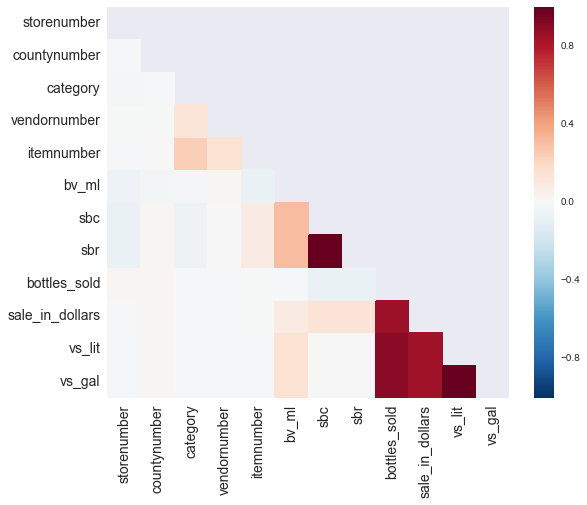

In [41]:
# Set the default matplotlib figure size to 7x7:
plt.rcParams['figure.figsize']=(9,7)

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(q1_2015_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(q1_2015_corr, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

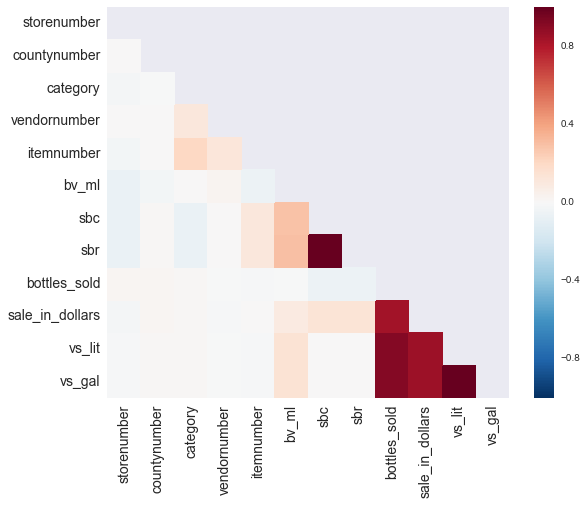

In [42]:
# Set the default matplotlib figure size to 7x7:
plt.rcParams['figure.figsize']=(9,7)

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(q2_2015_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(q2_2015_corr, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

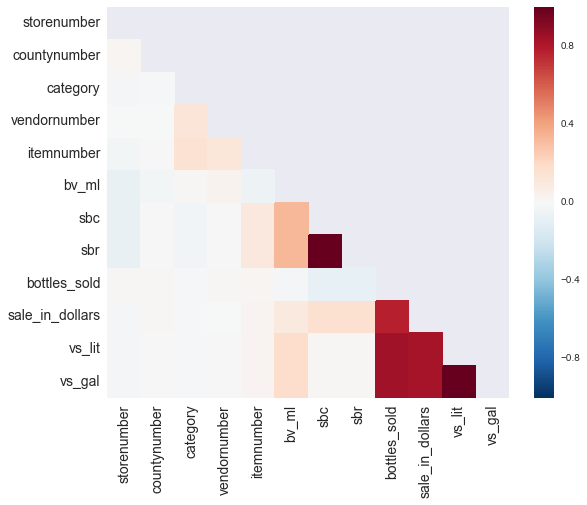

In [43]:
# Set the default matplotlib figure size to 7x7:
plt.rcParams['figure.figsize']=(9,7)

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(q3_2015_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(q3_2015_corr, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

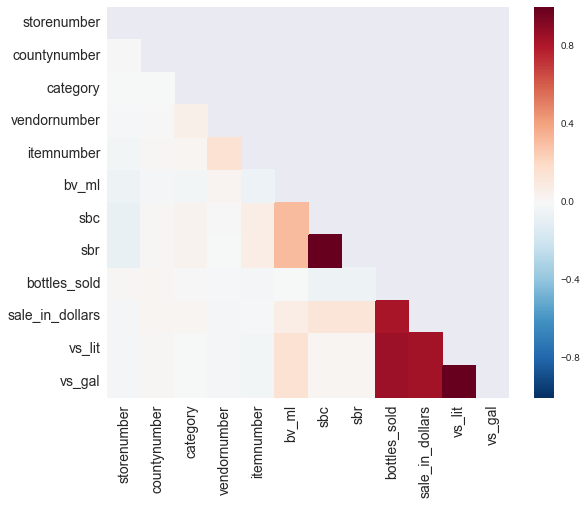

In [44]:
# Set the default matplotlib figure size to 7x7:
plt.rcParams['figure.figsize']=(9,7)

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(q4_2015_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(q4_2015_corr, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [45]:
# the models are being designed to predict which features are correlated or can
# be predictors of continuous variables 

In [46]:
## Define continuous features
cont_feats_regr = ['bottles_sold', 'sbr', 'sale_in_dollars']
ias_2015_q1[cont_feats_regr] = StandardScaler().fit_transform(
    ias_2015_q1[cont_feats_regr]
)

In [47]:
## Set alpha and generate N buckets of test dataframes

search_parameters = {
    "alpha": np.arange(10, -10, -0.01)
}

kf = KFold(len(ias_2015_q1), n_folds=10, shuffle=True, random_state=43)

In [48]:
## Define the models we want to test here

models = ['sale_in_dollars ~ bottles_sold','sale_in_dollars ~ bottles_sold + sbr', 
          'sale_in_dollars ~ bottles_sold + sbr * category', 
          'sale_in_dollars ~ bottles_sold + sbr * category * vendornumber']

In [49]:
## Generate R2 for Q1

for mm in models:
    outof_sample = []
    in_sample = []
    for train_index, test_index in kf:
        train_df = ias_2015_q1.iloc[train_index]
        y_train, X_train = patsy.dmatrices(mm, data=train_df, return_type='dataframe')
        model = sm.OLS(y_train, X_train).fit()
        in_sample.append( r2_score( model.predict(X_train),y_train) )
        test_df = ias_2015_q1.iloc[test_index]
        y_test, X_test = patsy.dmatrices(mm, data=test_df, return_type='dataframe')
        outof_sample.append(r2_score(model.predict(X_test),y_test))
    print mm
    print '----------------------------------------------------------------------'
    print '| R^2 outof_sample :',np.mean(outof_sample),'| R^2 in sample :', np.mean(in_sample),'|'
    print '----------------------------------------------------------------------\n'

sale_in_dollars ~ bottles_sold
----------------------------------------------------------------------
| R^2 outof_sample : 0.597110885665 | R^2 in sample : 0.624880481806 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr
----------------------------------------------------------------------
| R^2 outof_sample : 0.670643394984 | R^2 in sample : 0.692142288802 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr * category
----------------------------------------------------------------------
| R^2 outof_sample : 0.670995656923 | R^2 in sample : 0.692554758088 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr * category * vendornumber
----------------------------------------------------------------------
| R^2 outof_sample : 0.672826211562 | R^2 in sample : 0.694184845192 |
-------------------------------------

In [50]:
## Generate R2 for Q2 based on Q1 training

for mm in models:
    outof_sample = []
    in_sample = []
    for train_index, test_index in kf:
        train_df = ias_2015_q1.iloc[train_index]
        y_train, X_train = patsy.dmatrices(mm, data=train_df, return_type='dataframe')
        model = sm.OLS(y_train, X_train).fit()
        in_sample.append( r2_score( model.predict(X_train),y_train) )
        test_df = ias_2015_q3.iloc[test_index]
        y_test, X_test = patsy.dmatrices(mm, data=test_df, return_type='dataframe')
        outof_sample.append(r2_score(model.predict(X_test),y_test))
    print mm
    print '----------------------------------------------------------------------'
    print '| R^2 outof_sample :',np.mean(outof_sample),'| R^2 in sample :', np.mean(in_sample),'|'
    print '----------------------------------------------------------------------\n'

sale_in_dollars ~ bottles_sold
----------------------------------------------------------------------
| R^2 outof_sample : -341.748718665 | R^2 in sample : 0.624880481806 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr
----------------------------------------------------------------------
| R^2 outof_sample : -330.224599623 | R^2 in sample : 0.692142288802 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr * category
----------------------------------------------------------------------
| R^2 outof_sample : -330.206983861 | R^2 in sample : 0.692554758088 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr * category * vendornumber
----------------------------------------------------------------------
| R^2 outof_sample : -329.965813481 | R^2 in sample : 0.694184845192 |
-------------------------------------

In [51]:
## Generate R2 for Q3 based on Q1 training

for mm in models:
    outof_sample = []
    in_sample = []
    for train_index, test_index in kf:
        train_df = ias_2015_q1.iloc[train_index]
        y_train, X_train = patsy.dmatrices(mm, data=train_df, return_type='dataframe')
        model = sm.OLS(y_train, X_train).fit()
        in_sample.append( r2_score( model.predict(X_train),y_train) )
        test_df = ias_2015_q4.iloc[test_index]
        y_test, X_test = patsy.dmatrices(mm, data=test_df, return_type='dataframe')
        outof_sample.append(r2_score(model.predict(X_test),y_test))
    print mm
    print '----------------------------------------------------------------------'
    print '| R^2 outof_sample :',np.mean(outof_sample),'| R^2 in sample :', np.mean(in_sample),'|'
    print '----------------------------------------------------------------------\n'

sale_in_dollars ~ bottles_sold
----------------------------------------------------------------------
| R^2 outof_sample : -432.566495889 | R^2 in sample : 0.624880481806 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr
----------------------------------------------------------------------
| R^2 outof_sample : -417.657651286 | R^2 in sample : 0.692142288802 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr * category
----------------------------------------------------------------------
| R^2 outof_sample : -416.612163717 | R^2 in sample : 0.692554758088 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr * category * vendornumber
----------------------------------------------------------------------
| R^2 outof_sample : -415.690883863 | R^2 in sample : 0.694184845192 |
-------------------------------------

In [52]:
## Generate R2 for Q4 based on Q1 training

or mm in models:
    outof_sample = []
    in_sample = []
    for train_index, test_index in kf:
        train_df = ias_2015_q4.iloc[train_index]
        y_train, X_train = patsy.dmatrices(mm, data=train_df, return_type='dataframe')
        model = sm.OLS(y_train, X_train).fit()
        in_sample.append( r2_score( model.predict(X_train),y_train) )
        test_df = ias_2015_q4.iloc[test_index]
        y_test, X_test = patsy.dmatrices(mm, data=test_df, return_type='dataframe')
        outof_sample.append(r2_score(model.predict(X_test),y_test))
    print mm
    print '----------------------------------------------------------------------'
    print '| R^2 outof_sample :',np.mean(outof_sample),'| R^2 in sample :', np.mean(in_sample),'|'
    print '----------------------------------------------------------------------\n'

sale_in_dollars ~ bottles_sold
----------------------------------------------------------------------
| R^2 outof_sample : 0.514140608156 | R^2 in sample : 0.503541299878 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr
----------------------------------------------------------------------
| R^2 outof_sample : 0.583767219386 | R^2 in sample : 0.560654616318 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr * category
----------------------------------------------------------------------
| R^2 outof_sample : 0.583622686012 | R^2 in sample : 0.560807531026 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr * category * vendornumber
----------------------------------------------------------------------
| R^2 outof_sample : 0.585031253677 | R^2 in sample : 0.562786101187 |
-------------------------------------

In [53]:
# Q1 vs 2015 ANNUAL

kf2 = KFold(len(ias_2015), n_folds=10, shuffle=True, random_state=43)

for mm in models:
    outof_sample = []
    in_sample = []
    for train_index, test_index in kf2:
        train_df = ias_2015_q1.iloc[train_index]
        y_train, X_train = patsy.dmatrices(mm, data=train_df, return_type='dataframe')
        model = sm.OLS(y_train, X_train).fit()
        in_sample.append( r2_score( model.predict(X_train),y_train) )
        test_df = ias_2015_q3.iloc[test_index]
        y_test, X_test = patsy.dmatrices(mm, data=test_df, return_type='dataframe')
        outof_sample.append(r2_score(model.predict(X_test),y_test))
    print mm
    print '----------------------------------------------------------------------'
    print '| R^2 outof_sample :',np.mean(outof_sample),'| R^2 in sample :', np.mean(in_sample),'|'
    print '----------------------------------------------------------------------\n'

IndexError: positional indexers are out-of-bounds

In [54]:
# This is the same as the ridge coefficient by alpha calculator
def elasticnet_coefs(X, Y, alphas):
    coefs = []
    enet_reg = ElasticNet()
    for a in alphas:
        enet_reg.set_params(alpha=a, l1_ratio=0.05)
        enet_reg.fit(X, Y)
        coefs.append(enet_reg.coef_)
        
    return coefs

def ridge_coefs(X, Y, alphas):
    
    # set up the list to hold the different sets of coefficients:
    coefs = []
    
    # Set up a ridge regression object
    ridge_reg = Ridge()
    
    # Iterate through the alphas fed into the function:
    for a in alphas:
        
        # On each alpha reset the ridge model's alpha to the current one:
        ridge_reg.set_params(alpha=a)
        
        # fit or refit the model on the provided X, Y
        ridge_reg.fit(X, Y)
        
        # Get out the coefficient list (first element of the .coef_ attribute)
        coefs.append(ridge_reg.coef_[0])
        
    return coefs

# This is the same as the ridge coefficient by alpha calculator
def lasso_coefs(X, Y, alphas):
    coefs = []
    lasso_reg = Lasso()
    for a in alphas:
        lasso_reg.set_params(alpha=a)
        lasso_reg.fit(X, Y)
        coefs.append(lasso_reg.coef_)
        
    return coefs

In [55]:
kfolds = KFold(ias_2015_q1.shape[0], n_folds=5)

Y, X = patsy.dmatrices(models[2], data=ias_2015_q1)
Yoverfit, Xoverfit = patsy.dmatrices(models[2], data=ias_2015_q1)

In [56]:
# np.logspace gives us points between specified orders of magnitude on a logarithmic scale. It is base 10.
r_alphas = np.logspace(0, 5, 200)

# Get the coefficients for each alpha for the Ridge, using the function above
r_coefs = ridge_coefs(X, Y, r_alphas)

l_alphas = np.arange(0, 0.15, 0.0025)
l_coefs = lasso_coefs(X, Y, l_alphas)

enet_alphas = np.arange(0, 1.0, 0.005)
enet_coefs = elasticnet_coefs(X, Y, enet_alphas)

def ridge_lasso_cv_rsq(X, Y, r_alphas, l_alphas, e_alphas, kfolds, verbose=False):
    
    # lists to track mean R2s per alpha
    ridge_rsq = []
    lasso_rsq = []
    enet_rsq = []

    # initialize models
    lasso = Lasso()
    ridge = Ridge()
    enet = ElasticNet()

    print 'Lasso...'
    # iterate through Lasso alphas
    for la in l_alphas:
        
        if verbose: print la
        
        # set the current alpha to the model
        lasso.set_params(alpha=la)
        
        # keep track of fold R2s
        rsqs = []
        
        # iterate through the folds. Each iteration returns the training and
        # testing indices
        for traini, testi in kfolds:
            
            # run the current model with the subset training X and Y
            lasso.fit(X[traini], Y[traini])
            
            # append the R2 on the test set to the tracker
            rsqs.append(lasso.score(X[testi], Y[testi]))
            
        # append the mean of the R2s for this alpha to the R2 by alpha list
        lasso_rsq.append(np.mean(rsqs))

    print 'Ridge...'
    # Do the same process as above for ridge...
    for ra in r_alphas:
        
        if verbose: print ra
        
        ridge.set_params(alpha=ra)
        rsqs = []
        for traini, testi in kfolds:
            ridge.fit(X[traini], Y[traini])
            rsqs.append(ridge.score(X[testi], Y[testi]))
        ridge_rsq.append(np.mean(rsqs))
        
    print 'ElasticNet...'
    # Do the same process as above for ridge...
    for ea in e_alphas:
        
        if verbose: print ea
        
        enet.set_params(alpha=ea, l1_ratio=0.5)
        rsqs = []
        for traini, testi in kfolds:
            enet.fit(X[traini], Y[traini])
            rsqs.append(enet.score(X[testi], Y[testi]))
        enet_rsq.append(np.mean(rsqs))
        
    from sklearn.linear_model import LinearRegression
    
    linreg_rsq = []
    linreg = LinearRegression()
    for traini, testi in kfolds:
        linreg.fit(X[traini], Y[traini])
        linreg_rsq.append(linreg.score(X[testi], Y[[testi]]))
        
    linreg_rsq = np.mean(linreg_rsq)
        
    return ridge_rsq, lasso_rsq, enet_rsq, linreg_rsq

/Users/homerj/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:40: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/homerj/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:454: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/homerj/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/Users/homerj/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


In [57]:
# Get the ridge and lasso cross-validated R2s:
ridge_rsq, lasso_rsq, enet_rsq, linreg_rsq = ridge_lasso_cv_rsq(X, Y, r_alphas, l_alphas, enet_alphas, kfolds)

Lasso...


/Users/homerj/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


Ridge...
ElasticNet...


/Users/homerj/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:72: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


In [58]:
overfit_ridge_rsq, overfit_lasso_rsq, overfit_enet_rsq, overfit_linreg_rsq = ridge_lasso_cv_rsq(Xoverfit, Yoverfit,                                                                                                
                                                                                        r_alphas, l_alphas, 
                                                                                        enet_alphas, kfolds)

Lasso...


/Users/homerj/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


Ridge...
ElasticNet...


/Users/homerj/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:72: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


In [59]:
print 'Linear Regression R^2:', linreg_rsq
print 'Ridge best R^2:', np.max(ridge_rsq)
print 'Lasso best R^2:', np.max(lasso_rsq)
print 'ElasticNet best R^2:', np.max(enet_rsq)
print 'Overfitt Linear Regression R^2:', overfit_linreg_rsq
print 'Overfit Ridge best R^2:', np.max(overfit_ridge_rsq)
print 'Overfit Lasso best R^2:', np.max(overfit_lasso_rsq)
print 'Overfit ElasticNet best R^2:', np.max(overfit_enet_rsq)

Linear Regression R^2: 0.763255867783
Ridge best R^2: 0.763356152075
Lasso best R^2: 0.76334663823
ElasticNet best R^2: 0.763349249027
Overfitt Linear Regression R^2: 0.763255867783
Overfit Ridge best R^2: 0.763356152075
Overfit Lasso best R^2: 0.76334663823
Overfit ElasticNet best R^2: 0.763349249027


In [72]:
for mm in models:
    outof_sample = []
    in_sample = []
    for train_index, test_index in kf:
        train_df = ias_2015_q1.iloc[train_index]
        y_train, X_train = patsy.dmatrices(mm, data=train_df, return_type='dataframe')
        model = sm.OLS(y_train, X_train).fit()
        in_sample.append( r2_score( model.predict(X_train),y_train) )
        test_df = ias_2015_q4.iloc[test_index]
        y_test, X_test = patsy.dmatrices(mm, data=test_df, return_type='dataframe')
        outof_sample.append(r2_score(model.predict(X_test),y_test))
    print mm
    print '----------------------------------------------------------------------'
    print '| R^2 outof_sample :',np.mean(outof_sample),'| R^2 in sample :', np.mean(in_sample),'|'
    print '----------------------------------------------------------------------\n'

sale_in_dollars ~ bottles_sold
----------------------------------------------------------------------
| R^2 outof_sample : 0.503793822601 | R^2 in sample : 0.624880481806 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr
----------------------------------------------------------------------
| R^2 outof_sample : 0.577128457925 | R^2 in sample : 0.692142288802 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr * category
----------------------------------------------------------------------
| R^2 outof_sample : 0.578576768292 | R^2 in sample : 0.69255475809 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr * category * vendornumber
----------------------------------------------------------------------
| R^2 outof_sample : 0.580313755458 | R^2 in sample : 0.694184845517 |
--------------------------------------

In [102]:
y, X = patsy.dmatrices(models[2],
                       data=ias_2016_q1, 
                       return_type='dataframe')
model = sm.OLS(y, X)
results = model.fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:        sale_in_dollars   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                 3.784e+04
Date:                Fri, 23 Sep 2016   Prob (F-statistic):               0.00
Time:                        06:56:08   Log-Likelihood:            -3.4802e+05
No. Observations:               52360   AIC:                         6.960e+05
Df Residuals:                   52355   BIC:                         6.961e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept      171.5604     47.969      3.577   

In [62]:
outof_sample = []
in_sample = []

alphas = [0.2,0.1,-0.1,-0.2,-0.3,-0.4,-0.5]

for al in alphas:
    outof_sample = []
    in_sample = []
    for train_index, test_index in kf:
        train_df = ias_2015_q1.iloc[train_index]
        y_train, X_train = patsy.dmatrices(models[2], 
                                           data=train_df, return_type='dataframe')
        model = sm.OLS(y_train, X_train)
        results = model.fit_regularized(alpha=al)
        test_df = ias_2016_q1.iloc[test_index]
        in_sample.append(r2_score( results.predict(X_train) ,y_train))
        y_test, X_test = patsy.dmatrices(models[2], 
                                         data=test_df, return_type='dataframe')
        y_predicted = results.predict(X_test)
        outof_sample.append(r2_score(y_predicted,y_test))
    print 'alpha',al ,'R^2 outof_sample',np.mean(outof_sample),'R^2 in sample', np.mean(in_sample)

alpha 0.2 R^2 outof_sample -650.50992222 R^2 in sample 0.397603552303
alpha 0.1 R^2 outof_sample -484.87645771 R^2 in sample 0.591865764625
alpha -0.1 R^2 outof_sample -56.3278934515 R^2 in sample 0.0761767264067
alpha -0.2 R^2 outof_sample -16.7134520096 R^2 in sample 0.0244799146562
alpha -0.3 R^2 outof_sample -7.73503111917 R^2 in sample 0.012680614799
alpha -0.4 R^2 outof_sample -4.42078956016 R^2 in sample 0.00801415404381
alpha -0.5 R^2 outof_sample -2.85250968073 R^2 in sample 0.00563014779987
alpha -0.6 R^2 outof_sample -1.99100426935 R^2 in sample 0.00421821004647
alpha -0.7 R^2 outof_sample -1.46825820909 R^2 in sample 0.00329771366671
alpha -1 R^2 outof_sample -0.726113386685 R^2 in sample 0.00182766791183
alpha -2 R^2 outof_sample -0.190308704057 R^2 in sample 0.000419507636439
alpha -4 R^2 outof_sample -0.0629177095975 R^2 in sample -0.000268881215041
alpha -6 R^2 outof_sample -0.041137526691 R^2 in sample -0.000482190265463
alpha -9 R^2 outof_sample -0.042390129276 R^2 in

In [74]:
## Prediction data based on our selected preferred model.

y, X = patsy.dmatrices(models[2],
                       data=ias_2015_q1, 
                       return_type='dataframe')

y_test, X_test = patsy.dmatrices(models[2], 
                                 data=ias_2016_q1, return_type='dataframe')
model = sm.OLS(y, X)
results = model.fit()
predictions = results.predict(X_test)
print predictions

[  56.73723705  348.84284812   74.82277216 ...,   35.9627768   -11.6080008
  -29.73633007]


## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

In [64]:
for train_index, test_index in kf:
    train_df = ias_2015_q1.iloc[train_index]
    y_train, X_train = patsy.dmatrices(models[2], 
                                           data=train_df, return_type='dataframe')
    model = sm.OLS(y_train, X_train)
    results = model.fit_regularized(alpha=al)
    test_df = ias_2016_q1.iloc[test_index]
    in_sample.append(r2_score( results.predict(X_train) ,y_train))
    y_test, X_test = patsy.dmatrices(models[2], 
                                         data=test_df, return_type='dataframe')
    y_predicted = results.predict(X_test)
    outof_sample.append(r2_score(y_predicted,y_test))



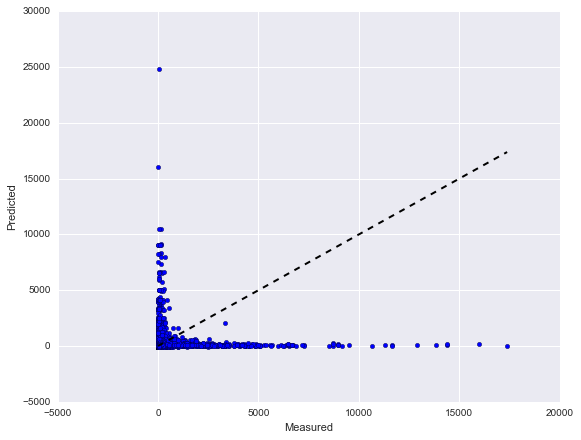

In [98]:
lr = linear_model.LinearRegression()
y = ias_2015_q1.sale_in_dollars

fig, ax = plt.subplots()
ax.scatter(y, predictions[:49791])
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.

See project3_deliverable